# **Detecting Phishing Emails**

In [75]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


### Data Exploration

In [4]:
emails = pd.read_csv('Phishing_Email.csv')
display(emails.head())
display(emails.info())
emails['Email Type'].value_counts()

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18650 entries, 0 to 18649
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18650 non-null  int64 
 1   Email Text  18634 non-null  object
 2   Email Type  18650 non-null  object
dtypes: int64(1), object(2)
memory usage: 437.2+ KB


None

Email Type
Safe Email        11322
Phishing Email     7328
Name: count, dtype: int64

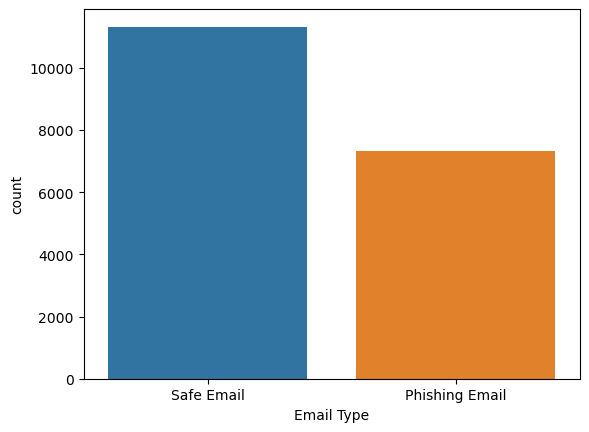

In [5]:
sns.countplot(x='Email Type', data=emails)
plt.show()

### Analysis

From the data exploration, we can tell that the data has two features, email text and type, with type being either phishing or safe. The bar plot shows a healthy distribution and no extreme imbalance.

### Data Preprocessing

In [8]:
#remove null
emails['Email Text'].fillna('No Content', inplace=True)

#TF-IDF evaluates term frequency to process language into numbers to use in models. Simple and great for text classification.
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
X = tfidf.fit_transform(emails['Email Text'])
Y = emails['Email Type'].apply(lambda x: 1 if x == 'Phishing Email' else 0)


### Model Building and Evaluation

In [10]:
# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train a model + L1 Regularization
model = LogisticRegression(penalty='l1', solver='saga', max_iter=200)
model.fit(X_train, Y_train)

# Predict and evaluate
Y_pred = model.predict(X_test)
print(f'Accuracy: {accuracy_score(Y_test, Y_pred):.2f}')
print(classification_report(Y_test, Y_pred))

Accuracy: 0.95
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2273
           1       0.93      0.96      0.94      1457

    accuracy                           0.95      3730
   macro avg       0.95      0.96      0.95      3730
weighted avg       0.96      0.95      0.95      3730



### Data Validation

In [12]:
validation_data = pd.read_csv('Ling.csv')
validation_data['body'].fillna('No Content', inplace=True)
X_validation = tfidf.transform(validation_data['body'])
Y_validation = validation_data['label']
Y_pred_validation = model.predict(X_validation)
print(classification_report(Y_validation, Y_pred_validation))

validation1_data = pd.read_csv('Enron.csv')
validation1_data['body'].fillna('No Content', inplace=True)
X_validation1 = tfidf.transform(validation1_data['body'])
Y_validation1 = validation1_data['label']
Y_pred_validation1 = model.predict(X_validation1)
print(classification_report(Y_validation1, Y_pred_validation1))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2401
           1       0.90      0.97      0.94       458

    accuracy                           0.98      2859
   macro avg       0.95      0.97      0.96      2859
weighted avg       0.98      0.98      0.98      2859

              precision    recall  f1-score   support

           0       0.96      0.95      0.96     15791
           1       0.95      0.95      0.95     13976

    accuracy                           0.95     29767
   macro avg       0.95      0.95      0.95     29767
weighted avg       0.95      0.95      0.95     29767



In [13]:

scores = cross_val_score(model, X, Y, cv=5, scoring='accuracy')
print(f"Cross-Validation Scores: {scores}")

Cross-Validation Scores: [0.94718499 0.95281501 0.94852547 0.9458445  0.9458445 ]


## Detection through a Deep Learning Model: Neural Networks

### Data Preparation

In [84]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(emails['Email Text'])
sequences = tokenizer.texts_to_sequences(emails['Email Text'])
neural_X = pad_sequences(sequences, maxlen=100)
neural_Y = emails['Email Type'].apply(lambda x: 1 if x == 'Phishing Email' else 0)
neural_X_train, neural_X_test, neural_Y_train, neural_Y_test = train_test_split(neural_X, neural_Y, test_size=0.2, random_state=42)
np.random.seed(42)
tf.random.set_seed(42)

### Model Architecture

In [85]:
neural_model = Sequential()
neural_model.add(Embedding(input_dim=10000, output_dim=100))
neural_model.add(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)))
neural_model.add(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01)))
neural_model.add(LSTM(32, kernel_regularizer=l2(0.01)))
neural_model.add(Dropout(0.5))
neural_model.add(Dense(1, activation='sigmoid'))



### Training and Evaluation

Epoch 1/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 46s 167ms/step - accuracy: 0.7085 - loss: 2.2622 - val_accuracy: 0.8523 - val_loss: 0.4107
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 37s 158ms/step - accuracy: 0.9175 - loss: 0.2972 - val_accuracy: 0.9507 - val_loss: 0.1669
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 38s 162ms/step - accuracy: 0.9608 - loss: 0.1397 - val_accuracy: 0.9558 - val_loss: 0.1418
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 37s 158ms/step - accuracy: 0.9715 - loss: 0.1005 - val_accuracy: 0.9536 - val_loss: 0.1671
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 40s 169ms/step - accuracy: 0.9745 - loss: 0.1100 - val_accuracy: 0.9542 - val_loss: 0.1791
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 36s 155ms/step - accuracy: 0.9758 - loss: 0.0999 - val_accuracy: 0.9571 - val_loss: 0.1431


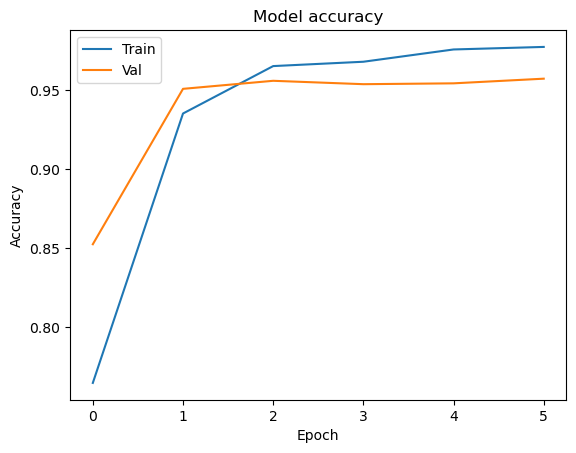

In [86]:
neural_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
history = neural_model.fit(neural_X_train, neural_Y_train, epochs=10, batch_size=64, validation_data=(neural_X_test, neural_Y_test), callbacks=[early_stopping, model_checkpoint])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [87]:
loss, accuracy = neural_model.evaluate(neural_X_test, neural_Y_test)
print(f"Validation Accuracy: {accuracy:.4f}")
predictions1 = neural_model.predict(neural_X_test)
predicted_labels1 = (predictions1 > 0.5).astype(int)
print("Classification Report:\n", classification_report(neural_Y_test, predicted_labels1))

117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9586 - loss: 0.1431
Validation Accuracy: 0.9558
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96      2273
           1       0.93      0.96      0.94      1457

    accuracy                           0.96      3730
   macro avg       0.95      0.96      0.95      3730
weighted avg       0.96      0.96      0.96      3730



### Data Validation

In [94]:
validation2_data = pd.read_csv('Enron.csv')
validation2_data['body'] = validation2_data['body'].astype(str).fillna('')
new_sequences = tokenizer.texts_to_sequences(validation2_data['body'])
new_X = pad_sequences(new_sequences, maxlen=100)
new_Y = validation2_data['label']
new_X_train, new_X_test, new_Y_train, new_Y_test = train_test_split(new_X, new_Y, test_size=0.2, random_state=42)
predictions = neural_model.predict(new_X_test)
predicted_labels = (predictions > 0.5).astype(int)
print("Classification Report:\n", classification_report(new_Y_test, predicted_labels))
print("Confusion Matrix:\n", confusion_matrix(new_Y_test, predicted_labels))

187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95      3185
           1       0.93      0.96      0.94      2769

    accuracy                           0.95      5954
   macro avg       0.95      0.95      0.95      5954
weighted avg       0.95      0.95      0.95      5954

Confusion Matrix:
 [[2982  203]
 [ 117 2652]]


## Exploring the Dangers of AI-Generated Threats

validation5_data = pd.read_csv('chatgptver.csv')
validation5_data['Email Text'] = validation5_data['Email Text'].astype(str).fillna('')
new_sequences5 = tokenizer.texts_to_sequences(validation5_data['Email Text'])
new_X5 = pad_sequences(new_sequences5, maxlen=100)
new_Y5 = validation5_data['Email Type']
new_X_train5, new_X_test5, new_Y_train5, new_Y_test5 = train_test_split(new_X5, new_Y5, test_size=0.2, random_state=42)
predictions5 = neural_model.predict(new_X_test5)
predicted_labels5 = (predictions5 > 0.5).astype(int)
print("Classification Report:\n", classification_report(new_Y_test5, predicted_labels5))
print("Confusion Matrix:\n", confusion_matrix(new_Y_test5, predicted_labels5))